In [1]:
import pygad.kerasga
import pygad
from pygad.kerasga import KerasGA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow 
import time
import os
from IPython.display import display, clear_output, HTML

In [2]:
MEMORY_SIZE = 5 # can remember last memory_size rounds
NUM_ROUNDS = MEMORY_SIZE
NUM_SOLUTION = 100

NUM_GENERATIONS = 300 # Number of generations.
NUM_PARENTS_MATING = 20 # Number of solutions to be selected as parents in the mating pool.

NUM_ACTIVATION_THRESHOLD = 0.6

fit_history = []

# memory array holds memory of all instances
g_memory_array = np.zeros(shape=(MEMORY_SIZE, 2)) + 1
g_buffer_memory_array = np.zeros(shape=(MEMORY_SIZE, 2)) + 1

In [3]:
model = tensorflow.keras.Sequential([
    tensorflow.keras.Input(shape=(g_memory_array.shape[0], g_memory_array.shape[1], 1)),
    tensorflow.keras.layers.Conv2D(filters=2, kernel_size=2, strides=2, activation='relu'),
    #tensorflow.keras.layers.MaxPool2D(),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(10, activation="relu"),
    tensorflow.keras.layers.Dense(10, activation="sigmoid"),
    tensorflow.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()
keras_ga = KerasGA(model=model, num_solutions=NUM_SOLUTION)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 2, 1, 2)        │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
def get_route(prediction):
    if prediction > 0.5:
        return 1
    return 0

def generate_loading_bar(progress, total=30):
    filled_length = int(total * progress)
    bar = '#' * filled_length + ' ' * (total - filled_length)
    return f"[{bar}] {progress * 100:.1f}%"

In [5]:
all_taken_routes = np.zeros(shape=(NUM_GENERATIONS + 1, NUM_ROUNDS, NUM_SOLUTION), dtype=int)
fit = np.zeros(shape=(NUM_SOLUTION))
t_array = []

display_handle = display(HTML("Starting..."), display_id=True)

def do_the_thing(ga_instance):
    if do_the_thing.gen == ga_instance.generations_completed:
        return
    do_the_thing.gen += 1

    global all_taken_routes, g_memory_array, t_array, display_handle, fit
    
    fit = np.zeros(shape=(NUM_SOLUTION))
    for round in range(NUM_ROUNDS):
        t_start = time.time()

        # 1 for up and 0 for down
        route = []
        for i, sol in enumerate(ga_instance.population):
            raw_prediction = pygad.kerasga.predict(model, sol, g_memory_array.reshape(1, MEMORY_SIZE, 2, 1))
            all_taken_routes[ga_instance.generations_completed, round, i] = get_route(raw_prediction[0])
        
        distribution = np.bincount(all_taken_routes[ga_instance.generations_completed, round], minlength=2)
        
        g_memory_array = np.append(g_memory_array, distribution).reshape((MEMORY_SIZE + 1, 2))[1:]

        for i in range(len(ga_instance.population)):
            r = all_taken_routes[ga_instance.generations_completed, round, i]
            fit[i] -= distribution[r] 


        t_end = time.time()
        t_array.append(t_end - t_start)
        clear_output(wait=True)
        display_handle.update(HTML(f"""Currently at <b>Generation {ga_instance.generations_completed}</b> and <b>Round {round}</b><br>
                                         Avg time for rounds {np.mean(t_array):.2f} s<br>
                                         ETA for remaining {NUM_ROUNDS - round} rounds: {np.mean(t_array) * (NUM_ROUNDS - round):.2f} s<br>
                                         ETA for all gens: {np.mean(t_array) * (NUM_ROUNDS * NUM_GENERATIONS - NUM_ROUNDS * (ga_instance.generations_completed - 1) - round)/60:.2f} min<br>
                                         <pre><code>{generate_loading_bar((NUM_ROUNDS * (ga_instance.generations_completed) + round)/(NUM_ROUNDS * (NUM_GENERATIONS + 1)))}</code></pre>"""))
 

do_the_thing.gen = -1

def fitness(ga_instance, solution, sol_idx):
    if sol_idx == None:
        sol_idx = 1
    global g_buffer_memory_array, g_memory_array, fit

    do_the_thing(ga_instance)

    return fit[sol_idx]
        
def on_gen(ga_instance):
    fit_history.append(np.mean(ga_instance.cal_pop_fitness()))

In [6]:
ga_instance = pygad.GA(num_generations=NUM_GENERATIONS,
                       num_parents_mating=NUM_PARENTS_MATING,
                       initial_population=keras_ga.population_weights,
                       mutation_type="adaptive",
                       mutation_probability=[0.2, 0.01],
                       suppress_warnings=True,
                       fitness_func=fitness,
                       on_generation=on_gen)

ga_instance.run()

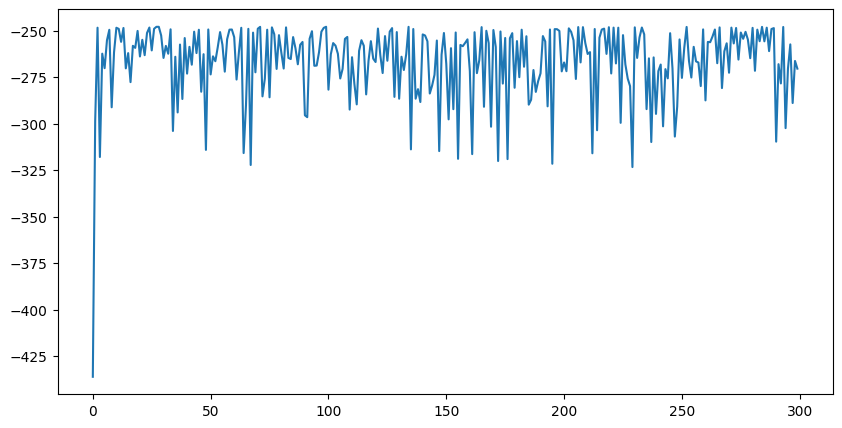

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(fit_history)), fit_history)

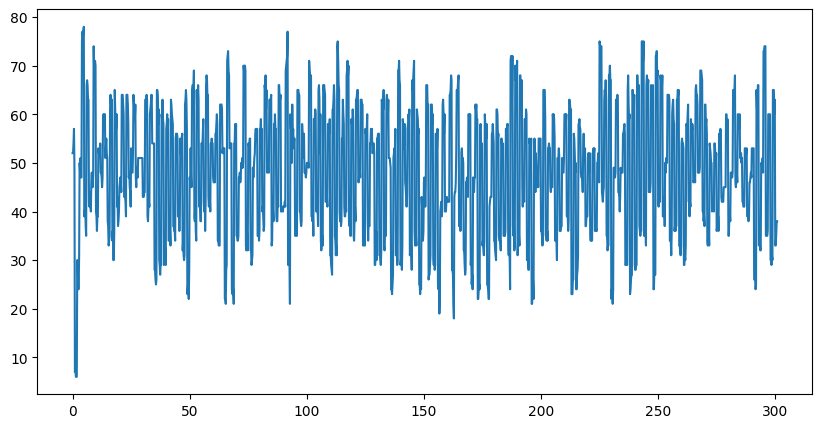

In [8]:
i = 0
r = []
for gen in all_taken_routes:
    for round in gen:
        r.append(np.bincount(round)[0])

plt.figure(figsize=(10, 5))
#plt.plot(range(len(fit_history)), fit_history)
plt.plot(np.array(range(len(r)))/NUM_ROUNDS, r)

In [9]:
save_dir = os.path.join(os.getcwd(), "bigger sim two roads", f"gen {NUM_GENERATIONS}, rounds {NUM_ROUNDS}, sol {NUM_SOLUTION}")
print(f"Saving at \"{save_dir}\"")
os.makedirs(save_dir, exist_ok=True)
np.savetxt(os.path.join(save_dir + "/routes.txt"), all_taken_routes.reshape((((NUM_GENERATIONS + 1) * NUM_ROUNDS), NUM_SOLUTION)), fmt='%d')
np.savetxt(os.path.join(save_dir + "/fitness.txt"), fit_history)

Saving at "c:\repos\game-theory-and-nn\braess paradox\bigger sim two roads\gen 300, rounds 5, sol 100"
